# Regression Analysis of Temporal Processes (Class 2) - Regression and Trend

First we import the core modules that will be used throughout this notebook:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Recode *natcrime*

In [2]:
# read in data from the trends-gss.csv file
gss = pd.read_csv("trends-gss.csv")

In [3]:
# subset the data to only include the 'natcrime', 'year', 'sex' variables
sub = gss[['natcrime', 'year', 'sex']]

# remove missing values
sub = sub.dropna()

In [5]:
# display value frequencies
sub['natcrime'].value_counts()

1.0    21500
2.0     8374
3.0     1907
Name: natcrime, dtype: int64

In [4]:
# Reverse-code natcrime
sub['n_natcrime'] = sub['natcrime'].replace([1, 3], [3, 1])

In [7]:
# make sure reverse-code was done correctly
sub['n_natcrime'].value_counts()

3.0    21500
2.0     8374
1.0     1907
Name: natcrime, dtype: int64

## Overall decline, esp. since 1996

In [5]:
# calculate mean natcrime of each year
by_year = sub.groupby('year', as_index = False).agg({"n_natcrime": "mean"})\
          .rename(columns = {"n_natcrime": "mean_natcrime"})

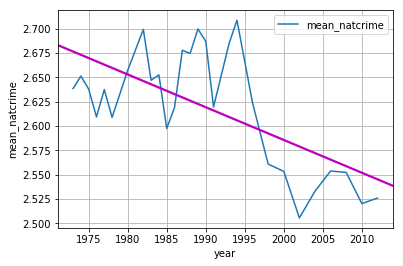

In [48]:
# plot the trend using matplotlib 
by_year.plot(x = 'year', y = 'mean_natcrime', grid = True)

# superimpose a fitted line using the seaborn package
sns.regplot(x = 'year', y = 'mean_natcrime', data = by_year, 
            scatter = False, ci = None, fit_reg = True, color = 'm')

## Super naive OLS 

(slide 22-23)   

To obtain statistical test results in Python, we can use the `statsmodels` module, which allows you to use R-style formulas with `pandas` data frames to fit models.

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# fit regression model
lm_natcrime = smf.ols('n_natcrime ~ year', data = sub).fit()
lm_natcrime.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natcrime   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     134.1
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           6.01e-31
Time:                        21:47:20   Log-Likelihood:                -28636.
No. Observations:               31781   AIC:                         5.728e+04
Df Residuals:                   31779   BIC:                         5.729e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1007      0.560     16.252      0.000       8.003      10.198
year          -0.0033      0.000    -11.580      0.000      -0.004      -0.003
==============================================================================
Omnibus:                     5834.253   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9584.905
Skew:                          -1.303   Prob(JB):                         0.00
Kurtosis:                       3.670   Cond. No.                     3.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Test for heteroskedasticity

(slide 24, 29)  

The `het_breuschpagan` function from the `statsmodels` module returns results of the Breush-Pagan test.    

Since the function only returns a tuple of numbers, for presentation purposes, we need to use `lzip` to print short descriptions of the output. 

In [7]:
from statsmodels.compat import lzip
name = ['BP', 'p-value', 
        'f-value', 'f p-value']

# use results of the model we fitted earlier

test = sm.stats.diagnostic.het_breuschpagan(lm_natcrime.resid, lm_natcrime.model.exog)
lzip(name, test)

[('BP', 14.741145772769679),
 ('p-value', 0.00012332531598101065),
 ('f-value', 14.747058306820179),
 ('f p-value', 0.00012317758190689008)]

## Applying robust standard errors

(slide 32)   

To apply robust (Huber-White, sandwich) standard error, specify `cov_type = 'HC1'` when fitting the model

In [12]:
lm_rob = smf.ols('n_natcrime ~ year', data = sub).fit(cov_type = 'HC1')
lm_rob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natcrime   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     129.3
Date:                Sun, 17 Jun 2018   Prob (F-statistic):           6.72e-30
Time:                        10:56:31   Log-Likelihood:                -28636.
No. Observations:               31781   AIC:                         5.728e+04
Df Residuals:                   31779   BIC:                         5.729e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1007      0.570     15.961      0.000       7.983      10.218
year          -0.0033      0.000    -11.370      0.000      -0.004      -0.003
==============================================================================
Omnibus:                     5834.253   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9584.905
Skew:                          -1.303   Prob(JB):                         0.00
Kurtosis:                       3.670   Cond. No.                     3.33e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 3.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Treating year as dummy variables

(slides 35 - 37)

We can treat `year` as categorical variables using the `C()` operator in the OLS formula

In [13]:
# refit model using 'year' as dummy variable
lm_natcrime2 = smf.ols('n_natcrime ~ C(year)', data = sub).fit()
lm_natcrime2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natcrime   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     11.63
Date:                Sun, 17 Jun 2018   Prob (F-statistic):           2.13e-50
Time:                        10:56:36   Log-Likelihood:                -28546.
No. Observations:               31781   AIC:                         5.715e+04
Df Residuals:                   31753   BIC:                         5.738e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.6384      0.016    166.395      0.000       2.607       2.670
C(year)[T.1974]     0.0128      0.022      0.571      0.568      -0.031       0.057
C(year)[T.1975]    -0.0006      0.022     -0.026      0.979      -0.045       0.043
C(year)[T.1976]    -0.0291      0.022     -1.299      0.194      -0.073       0.015
C(year)[T.1977]    -0.0011      0.022     -0.050      0.960      -0.045       0.043
C(year)[T.1978]    -0.0295      0.022     -1.329      0.184      -0.073       0.014
C(year)[T.1980]     0.0187      0.022      0.834      0.405      -0.025       0.063
C(year)[T.1982]     0.0607      0.021      2.856      0.004       0.019       0.102
C(year)[T.1983]     0.0085      0.022      0.387      0.699      -0.035       0.052
C(year)[T.1984]     0.0140      0.032      0.442      0.658      -0.048       0.076
C(year)[T.1985]    -0.0409      0.027     -1.502      0.133      -0.094       0.013
C(year)[T.1986]    -0.0194      0.028     -0.703      0.482      -0.073       0.035
C(year)[T.1987]     0.0393      0.029      1.334      0.182      -0.018       0.097
C(year)[T.1988]     0.0361      0.028      1.299      0.194      -0.018       0.091
C(year)[T.1989]     0.0612      0.027      2.264      0.024       0.008       0.114
C(year)[T.1990]     0.0485      0.028      1.712      0.087      -0.007       0.104
C(year)[T.1991]    -0.0188      0.027     -0.691      0.490      -0.072       0.035
C(year)[T.1993]     0.0465      0.027      1.742      0.081      -0.006       0.099
C(year)[T.1994]     0.0701      0.022      3.158      0.002       0.027       0.114
C(year)[T.1996]    -0.0149      0.022     -0.662      0.508      -0.059       0.029
C(year)[T.1998]    -0.0775      0.023     -3.410      0.001      -0.122      -0.033
C(year)[T.2000]    -0.0850      0.023     -3.758      0.000      -0.129      -0.041
C(year)[T.2002]    -0.1328      0.023     -5.828      0.000      -0.177      -0.088
C(year)[T.2004]    -0.1053      0.023     -4.656      0.000      -0.150      -0.061
C(year)[T.2006]    -0.0846      0.022     -3.799      0.000      -0.128      -0.041
C(year)[T.2008]    -0.0861      0.025     -3.465      0.001      -0.135      -0.037
C(year)[T.2010]    -0.1180      0.025     -4.771      0.000      -0.167      -0.070
C(year)[T.2012]    -0.1124      0.025     -4.516      0.000      -0.161      -0.064
==============================================================================
Omnibus:                     5862.026   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9648.903
Skew:                          -1.302   Prob(JB):                         0.00
Kurtosis:                       3.708   Cond. No.                         26.3
==============================================================================

Warn

## Linear hypothesis test 

(slide 40)

Using the fitted model and specify the hypothesis test as a string

In [14]:
hypothesis = '(C(year)[T.1998] = C(year)[T.2010])'
f_test = lm_natcrime2.f_test(hypothesis)
f_test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[2.61914336]]), p=0.10559135759522265, df_denom=31753, df_num=1>

p-value of 0.1056 indicates no change between crime rate in 1998 vs. 2010

## Periodization option 

(slide 41)

In [8]:
# Create a dummy variable `late` for years after 1996 as 1 and otherwise 0
sub2['late'] = ((sub.year > 1996)).astype(int)

In [16]:
# Fit periodization model
lm_natcrime_period = smf.ols('n_natcrime ~ late', data = sub).fit()
lm_natcrime_period.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natcrime   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     237.4
Date:                Sun, 17 Jun 2018   Prob (F-statistic):           2.29e-53
Time:                        10:56:45   Log-Likelihood:                -28584.
No. Observations:               31781   AIC:                         5.717e+04
Df Residuals:                   31779   BIC:                         5.719e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6506      0.004    661.883      0.000       2.643       2.658
late          -0.1116      0.007    -15.407      0.000      -0.126      -0.097
==============================================================================
Omnibus:                     5857.826   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9639.516
Skew:                          -1.304   Prob(JB):                         0.00
Kurtosis:                       3.695   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Quadratic trend

(slides 43 - 45)

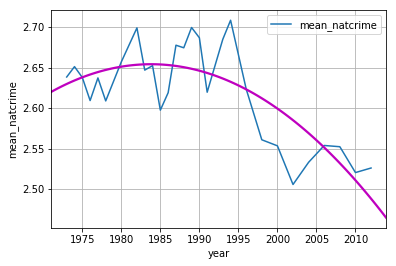

In [49]:
# plot the trend using matplotlib 
by_year.plot(x = 'year', y = 'mean_natcrime', grid = True)

# superimpose a quadratic fitted line using the seaborn package, specifying 'order = 2' for quadratic fit
sns.regplot(x = 'year', y = 'mean_natcrime', data = by_year, order = 2,
            scatter = False, ci = None, fit_reg = True, color = 'm')

## Testing for polynomials

(slide 46)

The RESET test, also known as Ramsey's REST test, is available in the `statsmodels` module as `reset_ramsey`.

In [9]:
from statsmodels.stats.outliers_influence import reset_ramsey
reset_ramsey(lm_natcrime, degree = 3)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[33.75817184]]), p=2.2623785217440584e-15, df_denom=31777, df_num=2>

## Testing for quadratic relationship

(slide 48)

In [19]:
lm_natcrimesq = smf.ols('n_natcrime ~ year + np.square(year)', data = sub).fit()
lm_natcrimesq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natcrime   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     95.06
Date:                Sun, 17 Jun 2018   Prob (F-statistic):           6.89e-42
Time:                        10:56:51   Log-Likelihood:                -28608.
No. Observations:               31781   AIC:                         5.722e+04
Df Residuals:                   31778   BIC:                         5.725e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -820.6841    111.087     -7.388      0.000   -1038.419    -602.949
year                0.8302      0.112      7.441      0.000       0.612       1.049
np.square(year)    -0.0002    2.8e-05     -7.470      0.000      -0.000      -0.000
==============================================================================
Omnibus:                     5837.624   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9592.091
Skew:                          -1.302   Prob(JB):                         0.00
Kurtosis:                       3.680   Cond. No.                     1.32e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Cubic trend

(slides 51-52)

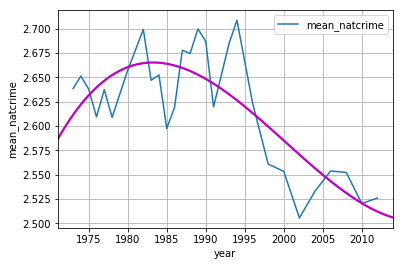

In [50]:
# plot the trend using matplotlib 
by_year.plot(x = 'year', y = 'mean_natcrime', grid = True)

# superimpose a quadratic fitted line using the seaborn package, specifying 'order = 3' for cubic fit
sns.regplot(x = 'year', y = 'mean_natcrime', data = by_year, order = 3,
            scatter = False, ci = None, fit_reg = True, color = 'm')

## Cubic relationship (*WRONG RESULTS*)

(slide 53)

In [21]:
lm_natcrimecu = smf.ols('n_natcrime ~ year + np.square(year) + np.power(year, 3)', data = sub).fit()
lm_natcrimecu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natcrime   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     94.93
Date:                Sun, 17 Jun 2018   Prob (F-statistic):           7.86e-42
Time:                        10:56:56   Log-Likelihood:                -28608.
No. Observations:               31781   AIC:                         5.722e+04
Df Residuals:                   31778   BIC:                         5.725e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0006    8.4e-05     -7.264      0.000      -0.001      -0.000
year                 -0.4049      0.056     -7.264      0.000      -0.514      -0.296
np.square(year)       0.0004    5.6e-05      7.329      0.000       0.000       0.001
np.power(year, 3) -1.036e-07   1.41e-08     -7.370      0.000   -1.31e-07    -7.6e-08
==============================================================================
Omnibus:                     5837.580   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9591.990
Skew:                          -1.302   Prob(JB):                         0.00
Kurtosis:                       3.680   Cond. No.                     5.03e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+16. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Trend with interactions 

(slides 58 - 62)

In [17]:
# map the indicators variables for sex to 'Male' and 'Female'
sub2['sex'].replace({1: 'Male', 2: 'Female'}, inplace = True)

In [18]:
# get mean of 'natcrime' by year and sex, present it in the form of a pivot table for easier plotting
by_year_sex = sub.groupby(['year', 'sex']).mean()['n_natcrime'].unstack()

# see how the new data frame looks like
by_year_sex.head()

sex,Female,Male
year,,
1973,2.669399,2.604755
1974,2.661269,2.640060
1975,2.662730,2.608150
1976,2.635659,2.577465
1977,2.680879,2.585997


Text(0,0.5,'mean')

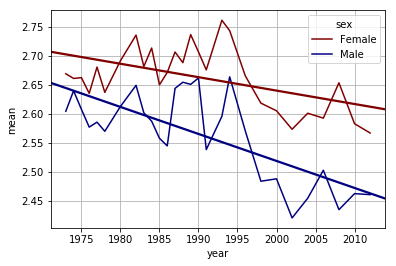

In [55]:
# plot the two trend lines, specifying the colors
ax = by_year_sex.plot(color = ['maroon', 'navy'], grid = True)

# plot the two regression lines
sns.regplot(x = by_year_sex.index, y = 'Female', data = by_year_sex,
            scatter = False, ci = None, fit_reg = True, color = 'maroon')
sns.regplot(x = by_year_sex.index, y = 'Male', data = by_year_sex,
            scatter = False, ci = None, fit_reg = True, color = 'navy')

# rename y-label
ax.set_ylabel('mean')

## Quadratic fit for crime rate by gender

(slides 64-65)

Text(0,0.5,'mean')

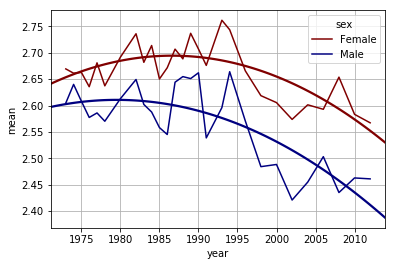

In [56]:
ax = by_year_sex.plot(color = ['maroon', 'navy'], grid = True)

# specify "order = 2" for quadratic fit
sns.regplot(x = by_year_sex.index, y = 'Male', data = by_year_sex, order = 2, 
            scatter = False, ci = None, fit_reg = True, color = 'navy')
sns.regplot(x = by_year_sex.index, y = 'Female', data = by_year_sex, order = 2, 
            scatter = False, ci = None, fit_reg = True, color = 'maroon')

# rename y-label
ax.set_ylabel('mean')

## Cubic fit for crime rate by gender

(slides 67-68)

Text(0,0.5,'mean')

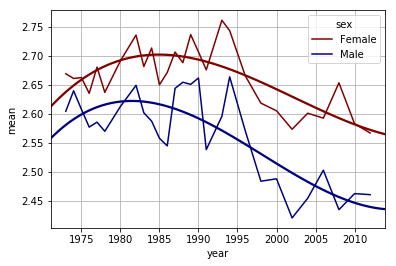

In [57]:
ax = by_year_sex.plot(color = ['maroon', 'navy'], grid = True)

# specify "order = 3" for cubic fit
sns.regplot(x = by_year_sex.index, y = 'Female', data = by_year_sex, order = 3, 
            scatter = False, ci = None, fit_reg = True, color = 'maroon')
sns.regplot(x = by_year_sex.index, y = 'Male', data = by_year_sex, order = 3, 
            scatter = False, ci = None, fit_reg = True, color = 'navy')

ax.set_ylabel('mean')

## Concerns for crime 

(slide 70-76)

First, let's look at those who have a lot of concerns about crime. Note that `np.where()` in Python is functionally equivalent to `ifelse()` in R

Text(0,0.5,'mean')

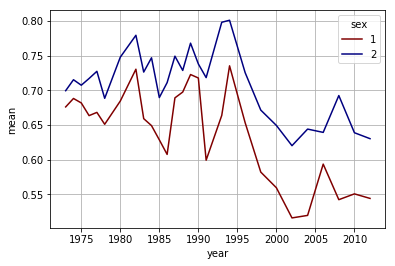

In [10]:
# create new variable 'muchconcern' as an indicator variable for when natcrime == 3. np.where()
sub['muchconcern'] = np.where((sub.n_natcrime == 3), 1, 0)

# calculate mean natcrime for muchconcern
by_year_sex = sub.groupby(['year', 'sex']).mean()['muchconcern'].unstack()

by_year_sex.plot(color = ['maroon', 'navy'], grid = True).set_ylabel('mean')

Next, look at those who have some concerns about crime:

Text(0,0.5,'mean')

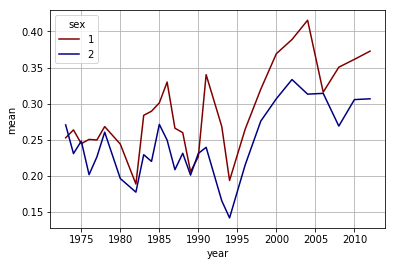

In [11]:
sub['someconcern'] = np.where((sub.natcrime == 2), 1, 0)

by_year_sex = sub.groupby(['year', 'sex']).mean()['someconcern'].unstack()

by_year_sex.plot(color = ['maroon', 'navy'], grid = True).set_ylabel('mean')

Finally, those who have little concern about crime:

Text(0,0.5,'mean')

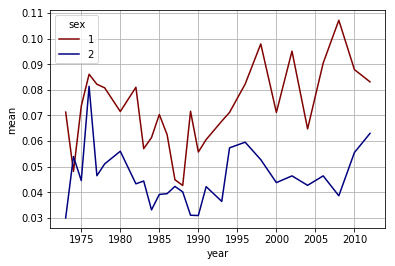

In [12]:
sub['littleconcern'] = np.where((sub.n_natcrime == 1), 1, 0)

by_year_sex = sub.groupby(['year', 'sex']).mean()['littleconcern'].unstack()

by_year_sex.plot(color = ['maroon', 'navy'], grid = True).set_ylabel('mean')

## The male OLS regression

(slide 78)

In [23]:
# calculate ols results for males, applying robust standard errors
ols_natcrimeM = smf.ols('n_natcrime ~ year', data = sub[sub.sex == 'Male']).fit(cov_type = 'HC1')

ols_natcrimeM.summary()
#ols_natcrimeM.get_robustcov_results(ols_natcrimeM)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natcrime   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     103.1
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           3.81e-24
Time:                        21:50:46   Log-Likelihood:                -13594.
No. Observations:               14286   AIC:                         2.719e+04
Df Residuals:                   14284   BIC:                         2.721e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.5825      0.888     13.044      0.000       9.842      13.323
year          -0.0045      0.000    -10.155      0.000      -0.005      -0.004
==============================================================================
Omnibus:                     2088.880   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3151.011
Skew:                          -1.144   Prob(JB):                         0.00
Kurtosis:                       3.237   Cond. No.                     3.32e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 3.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## The female OLS regression

(slide 79)

In [22]:
# calculate ols results for females, applying robust standard errors
ols_natcrimeF = smf.ols('n_natcrime ~ year', data = sub[sub.sex == 'Female']).fit(cov_type = 'HC1')
ols_natcrimeF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natcrime   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     36.98
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           1.22e-09
Time:                        21:50:32   Log-Likelihood:                -14847.
No. Observations:               17495   AIC:                         2.970e+04
Df Residuals:                   17493   BIC:                         2.971e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1193      0.733      9.709      0.000       5.682       8.557
year          -0.0022      0.000     -6.081      0.000      -0.003      -0.002
==============================================================================
Omnibus:                     3854.337   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6959.348
Skew:                          -1.442   Prob(JB):                         0.00
Kurtosis:                       4.108   Cond. No.                     3.35e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 3.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## The Z test 

(slide 82)

In [24]:
import scipy.stats as stats

# Get coefficient and standard error for the 'year' variable for the Male and Female models
natcrimeMb = ols_natcrimeM.params['year']
natcrimeMse = ols_natcrimeM.bse['year']

natcrimeFb = ols_natcrimeF.params['year']
natcrimeFse = ols_natcrimeF.bse['year']

# applying the Z formula
b1minusb2 = natcrimeMb - natcrimeFb
denom = np.sqrt(np.square(natcrimeMse)+np.square(natcrimeFse))
Z = b1minusb2/denom
pvalue = 1 - stats.norm.cdf(abs(Z))

In [25]:
pvalue

3.769304379941385e-05

## The interacted OLS regression 

(slide 84)

In [129]:
# create indicator variable 'male'
sub['male'] = sub['sex'] == 'Male'

# obtain results for interacted ols regression, appylying robust standard errors
ols_natcrime4 = smf.ols('n_natcrime ~ year*male', data = sub).fit(cov_type = 'HC1')
ols_natcrime4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natcrime   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     111.6
Date:                Sun, 17 Jun 2018   Prob (F-statistic):           6.97e-72
Time:                        14:12:47   Log-Likelihood:                -28524.
No. Observations:               31781   AIC:                         5.706e+04
Df Residuals:                   31777   BIC:                         5.709e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.1193      0.733      9.709      0.000       5.682       8.557
male[T.True]          4.4632      1.152      3.876      0.000       2.206       6.720
year                 -0.0022      0.000     -6.081      0.000      -0.003      -0.002
year:male[T.True]    -0.0023      0.001     -3.959      0.000      -0.003      -0.001
==============================================================================
Omnibus:                     5759.834   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9407.121
Skew:                          -1.290   Prob(JB):                         0.00
Kurtosis:                       3.665   Cond. No.                     8.40e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 8.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0,0.5,'mean')

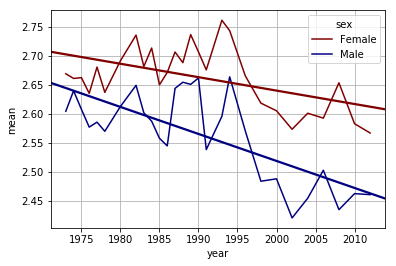

In [130]:
by_year_sex = sub.groupby(['year', 'sex']).mean()['n_natcrime'].unstack()

ax = by_year_sex.plot(color = ['maroon', 'navy'], grid = True)

sns.regplot(x = by_year_sex.index, y = 'Male', data = by_year_sex,
            scatter = False, ci = None, fit_reg = True, color = 'navy')
sns.regplot(x = by_year_sex.index, y = 'Female', data = by_year_sex,
            scatter = False, ci = None, fit_reg = True, color = 'maroon')

ax.set_ylabel('mean')

## Prediction

(slides 86-87)

First we need to create a new dataframe of values to be predicted on using the model we fitted. This contains a column for year and a boolean column for male. Per the `pandas` documentation, we can define a `expand_grid` function similar to the `expand.grid()` function in R:

In [36]:
import itertools 

def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns = data_dict.keys())

In [37]:
pred_dat = expand_grid(
            {'year': sub.year.unique(), 
             'male': [True, False]})

Make predictions on the `pred_dat` dataframe

In [38]:
pred_dat['predicted value'] = ols_natcrime4.predict(pred_dat)

To plot year vs. predicted values based on a third column `male`, we can first `pivot` the data, then use `pandas.dataframe.plot` on the pivoted dataframe.

Text(0,0.5,'predicted value')

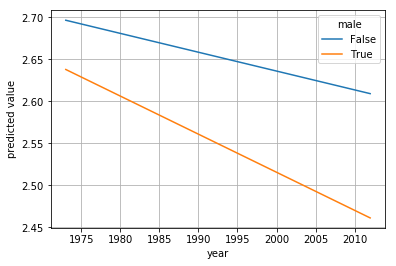

In [65]:
pred_dat.pivot(index = 'year', columns = 'male', values = 'predicted value').plot(grid = True).set_ylabel('predicted value')

## The male logit regression

(slide 91)

In [66]:
# make year variable relative to the first year (slide 90)
sub['n_year'] = sub['year'] - min(sub['year'])

In [136]:
lrm_muchconcernM = smf.glm('muchconcern ~ n_year', data = sub[sub.sex == 'Male'], family=sm.families.Binomial()).fit()
lrm_muchconcernM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            muchconcern   No. Observations:                14286
Model:                            GLM   Df Residuals:                    14284
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9275.8
Date:                Sun, 17 Jun 2018   Deviance:                       18552.
Time:                        14:42:38   Pearson chi2:                 1.43e+04
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8596      0.030     28.230      0.000       0.800       0.919
n_year        -0.0174      0.001    -11.888      0.000      -0.020      -0.015
==============================================================================
"""

## The female logit regression

(slide 92)

In [137]:
lrm_muchconcernF = smf.glm('muchconcern ~ n_year', data = sub[sub.sex == 'Female'], family=sm.families.Binomial()).fit()
lrm_muchconcernF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            muchconcern   No. Observations:                17495
Model:                            GLM   Df Residuals:                    17493
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10544.
Date:                Sun, 17 Jun 2018   Deviance:                       21088.
Time:                        14:42:42   Pearson chi2:                 1.75e+04
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0636      0.029     36.456      0.000       1.006       1.121
n_year        -0.0107      0.001     -7.659      0.000      -0.013      -0.008
==============================================================================
"""

## The Chi-sq test

(slides 93-94)

In [138]:
bM = lrm_muchconcernM.params['n_year']
bF = lrm_muchconcernF.params['n_year']
vM = lrm_muchconcernM.cov_params()['n_year']['n_year']
vF = lrm_muchconcernF.cov_params()['n_year']['n_year']
chi_sq = np.square(bM - bF)/(vM + vF)

To calculate test statistics in Python, we can use probability distributions in `scipy.stats`

In [139]:
import scipy.stats as stats

# calculate p-value for the chi-square test
1 - stats.chi2.cdf(x = chi_sq, df = 1)

0.0009801211543221111

## Periodization 

(slide 104)

In [143]:
sub['late'] = np.where(sub.year > 1996, 1, 0)

In [150]:
# map the indicators variables for sex back to 1 and 2
sub['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)

lm_natcrime_period_int = smf.ols('n_natcrime ~ late*C(sex)', data = sub).fit()
lm_natcrime_period_int.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natcrime   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     153.2
Date:                Sun, 17 Jun 2018   Prob (F-statistic):           1.48e-98
Time:                        14:50:27   Log-Likelihood:                -28475.
No. Observations:               31781   AIC:                         5.696e+04
Df Residuals:                   31777   BIC:                         5.699e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.6070      0.006    438.124      0.000       2.595       2.619
C(sex)[T.2]          0.0794      0.008      9.895      0.000       0.064       0.095
late                -0.1417      0.011    -13.157      0.000      -0.163      -0.121
late:C(sex)[T.2]     0.0545      0.015      3.754      0.000       0.026       0.083
==============================================================================
Omnibus:                     5783.866   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9462.520
Skew:                          -1.291   Prob(JB):                         0.00
Kurtosis:                       3.689   Cond. No.                         6.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Unpooled regressions 

In [237]:
gss['south'] = np.where(((gss.region > 4) & (gss.region < 8)), 1, 0)
gss['rconarmy'] = 4 - gss.conarmy

### Regression for 1970 - 1980 (slide 112)

In [238]:
# subset the data to include only the relevant years
sub70 = gss[(gss['year'] >= 1970) & (gss['year'] <= 1980)]

# build model using subsetted data
army70 = smf.ols('rconarmy ~ age + C(sex) + educ + attend + south + year', data = sub70).fit()
army70.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rconarmy   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     80.44
Date:                Sun, 17 Jun 2018   Prob (F-statistic):           1.21e-98
Time:                        16:12:30   Log-Likelihood:                -9960.2
No. Observations:                9972   AIC:                         1.993e+04
Df Residuals:                    9965   BIC:                         1.998e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      20.3048      5.848      3.472      0.001       8.842      31.768
C(sex)[T.2]    -0.0390      0.013     -2.919      0.004      -0.065      -0.013
age             0.0021      0.000      5.099      0.000       0.001       0.003
educ           -0.0301      0.002    -13.585      0.000      -0.034      -0.026
attend          0.0152      0.003      5.952      0.000       0.010       0.020
south           0.1323      0.014      9.267      0.000       0.104       0.160
year           -0.0091      0.003     -3.061      0.002      -0.015      -0.003
==============================================================================
Omnibus:                      726.940   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.259
Skew:                          -0.278   Prob(JB):                     1.44e-76
Kurtosis:                       2.271   Cond. No.                     1.76e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regression for 2000 - 2010 (slide 114)

In [203]:
sub00 = gss[(gss['year'] >= 2000) & (gss['year'] <= 2010)]
army00 = smf.ols('rconarmy ~ age + C(sex) + educ + attend + south + year', data = sub00).fit()
army00.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rconarmy   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     24.15
Date:                Sun, 17 Jun 2018   Prob (F-statistic):           1.69e-28
Time:                        15:27:34   Log-Likelihood:                -8168.6
No. Observations:                8122   AIC:                         1.635e+04
Df Residuals:                    8115   BIC:                         1.640e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -12.4084      4.202     -2.953      0.003     -20.646      -4.171
C(sex)[T.2]    -0.1080      0.015     -7.255      0.000      -0.137      -0.079
age             0.0003      0.000      0.650      0.516      -0.001       0.001
educ           -0.0108      0.002     -4.419      0.000      -0.016      -0.006
attend          0.0150      0.003      5.465      0.000       0.010       0.020
south           0.0795      0.015      5.159      0.000       0.049       0.110
year            0.0074      0.002      3.546      0.000       0.003       0.012
==============================================================================
Omnibus:                      705.487   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              670.504
Skew:                          -0.642   Prob(JB):                    2.52e-146
Kurtosis:                       2.422   Cond. No.                     1.15e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Comparing standardized coefficients 

(slide 117)

To calculate standardized regression coefficients in Python, we need to first standardize the data, then refit the model. 

We can standardize the data using the `sklearn.preprocessing` package. 

In [239]:
from sklearn.preprocessing import StandardScaler

# subset the data to only include the relevant columns and remove NA's
sub70 = sub70[['rconarmy', 'sex', 'age', 'educ', 'attend', 'south', 'year']]
sub70 = sub70.dropna()

In [241]:
# standardize the data, which returns a numpy array
sub70_scaled = standard_scaler.fit_transform(sub70)

# convert to pandas dataframe in order to refit the model
sub70_standardized = pd.DataFrame(sub70_scaled, columns = ['rconarmy', 'sex', 'age', 'educ', 'attend', 'south', 'year'])

In [242]:
# refit model using standardized dataframe
smf.ols('rconarmy ~ age + sex + educ + attend + south + year', data = sub70_standardized).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rconarmy   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     80.44
Date:                Sun, 17 Jun 2018   Prob (F-statistic):           1.21e-98
Time:                        16:14:33   Log-Likelihood:                -13914.
No. Observations:                9972   AIC:                         2.784e+04
Df Residuals:                    9965   BIC:                         2.789e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.601e-16      0.010   -4.7e-14      1.000      -0.019       0.019
age            0.0533      0.010      5.099      0.000       0.033       0.074
sex           -0.0289      0.010     -2.919      0.004      -0.048      -0.009
educ          -0.1420      0.010    -13.585      0.000      -0.162      -0.121
attend         0.0599      0.010      5.952      0.000       0.040       0.080
south          0.0921      0.010      9.267      0.000       0.073       0.112
year          -0.0300      0.010     -3.061      0.002      -0.049      -0.011
==============================================================================
Omnibus:                      726.940   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.259
Skew:                          -0.278   Prob(JB):                     1.44e-76
Kurtosis:                       2.271   Cond. No.                         1.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [243]:
# Do the above steps again for the 2000-2010 dataframe

sub00 = sub00_10[['rconarmy', 'age', 'sex', 'educ', 'attend', 'south', 'year']]
sub00 = sub00.dropna()

sub00_scaled = standard_scaler.fit_transform(sub00)
sub00_standardized = pd.DataFrame(sub00_scaled, columns = ['rconarmy', 'age', 'sex', 'educ', 'attend', 'south', 'year'])

In [244]:
smf.ols('rconarmy ~ age + sex + educ + attend + south + year', data = sub00_standardized).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rconarmy   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     24.15
Date:                Sun, 17 Jun 2018   Prob (F-statistic):           1.69e-28
Time:                        16:15:00   Log-Likelihood:                -11453.
No. Observations:                8122   AIC:                         2.292e+04
Df Residuals:                    8115   BIC:                         2.297e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.618e-15      0.011   1.47e-13      1.000      -0.022       0.022
age            0.0073      0.011      0.650      0.516      -0.015       0.029
sex           -0.0804      0.011     -7.255      0.000      -0.102      -0.059
educ          -0.0490      0.011     -4.419      0.000      -0.071      -0.027
attend         0.0618      0.011      5.465      0.000       0.040       0.084
south          0.0575      0.011      5.159      0.000       0.036       0.079
year           0.0391      0.011      3.546      0.000       0.017       0.061
==============================================================================
Omnibus:                      705.487   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              670.504
Skew:                          -0.642   Prob(JB):                    2.52e-146
Kurtosis:                       2.422   Cond. No.                         1.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Comparing coefficients and Z-scores

(slides 119-120)

Although the `broom` package does not exist in Python, we can apply the same `tidy` function by hand to achieve the same results:

In [228]:
# obtain coefficient estimates and standard errors
army70coef = army70.params
army70se = army70.bse

# put into dataframe and rename columns
a70 = pd.concat([army70coef, army70se], axis = 1)
a70.columns = ['e70', 'se70']

In [229]:
# Do the same for the 2000-2010 model, but rename the columns differently
army00coef = army00.params
army00se = army00.bse
a00 = pd.concat([army00coef, army00se], axis = 1)
a00.columns = ['estimate', 'std_error']

In [230]:
# concatenate results into one pandas dataframe
new = pd.concat([a70, a00], axis = 1)

In [232]:
# applying the Z formula
new['b1minusb2'] = new.e70 - new.estimate
new['denom'] = np.sqrt(np.square(new.se70)+np.square(new.std_error))
new['Z'] = new.b1minusb2/new.denom
new['pvalue'] = 1 - stats.norm.cdf(new.Z)

In [233]:
newest = new[['e70', 'estimate', 'Z', 'pvalue']]

In [234]:
newest

,e70,estimate,Z,pvalue
Intercept,20.304835,-12.408412,4.542912,0.000003
C(sex)[T.2],-0.038995,-0.107963,3.448804,0.000282
age,0.002067,0.000281,3.016570,0.001278
educ,-0.030111,-0.010776,-5.866964,1.000000
attend,0.015188,0.014972,0.057579,0.477042
south,0.132252,0.079490,2.512355,0.005996
year,-0.009062,0.007433,-4.547583,0.999997


## Visualizaing increased confidence in the military

(slides 122-123)

In [235]:
by_year = gss.groupby('year').mean()['rconarmy']

Text(0,0.5,'mean')

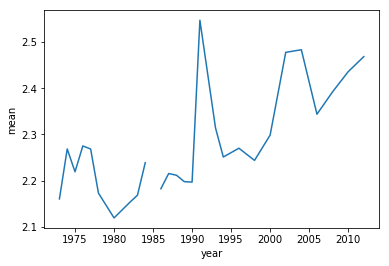

In [236]:
by_year.plot().set_ylabel('mean')